In [1]:
# Add anna to the path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../anna'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = "../../../data"

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import anna.data.dataset.reuters21578 as reuters
import anna.model.premade as models
import anna.summary.extract as summary
import anna.summary.plots as plots

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
# Load data
train_docs, test_docs, unused_docs, labels = reuters.fetch_and_parse(DATA_DIR)

# Standard Reuters Config
val_size = 777
epochs = 200
shuffle = 10000
eval_every = 100

In [4]:
# Create MLP classifier
for layers in range(4):
    for size in [256, 512, 1024, 2048, 4096, 8192]:
        model = models.AVGxBR(DATA_DIR, labels, layers=layers, hidden_size=size,
                              name="{}_{}".format(layers, size),
                              folder_name="model-sizes")

        # Train and evaluate
        print("Model: {}, Layers: {}, Size: {}".format(model, layers, size))
        model.train(train_docs, test_docs=None,
                    val_size=val_size, epochs=epochs, shuffle=shuffle, eval_every=eval_every)

        # Delete to save memory
        del model

In [5]:
model_path = os.path.join(DATA_DIR, "model-sizes")
metrics_path = os.path.join(model_path, "metrics.json")

In [6]:
# Load from tfrecord event files
metrics = summary.parse_all(model_path)
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

In [7]:
# Load from json serialized metrics
#with open(metrics_path, "r") as f:
#    metrics = json.load(f)

In [8]:
num_epochs = min([len(m["val"]["perf/accuracy"]) for m in metrics.values()])
num_epochs = min([num_epochs, 100])

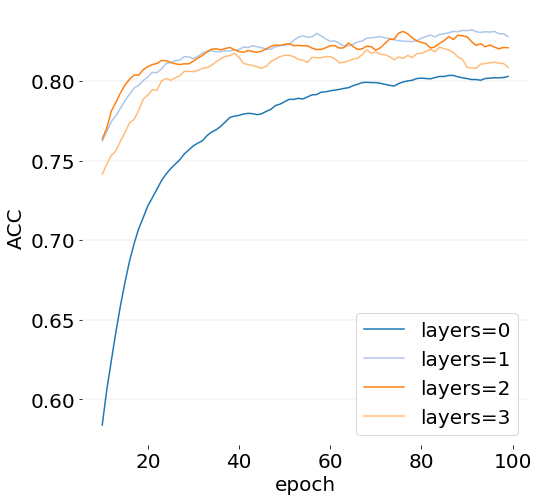

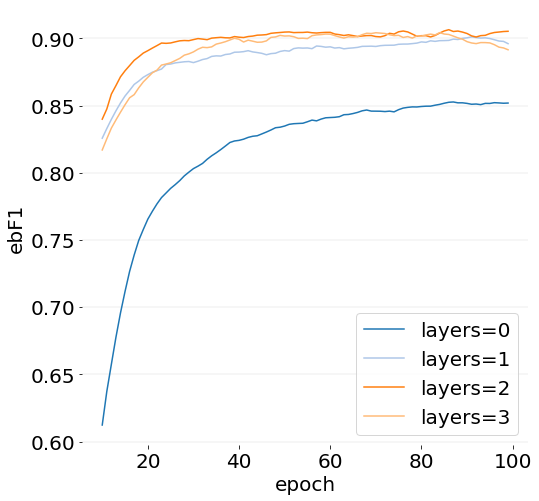

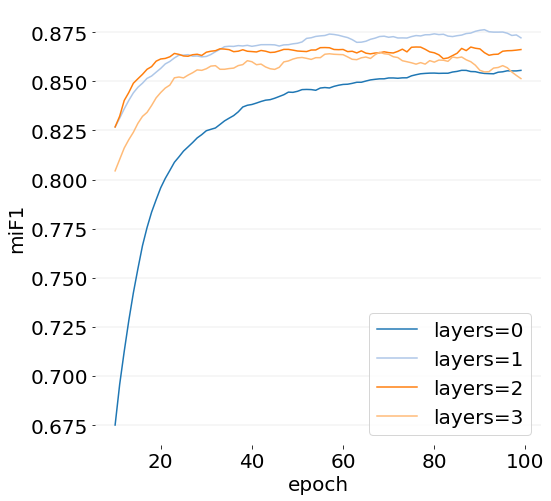

In [9]:
remove_first = 10

x = range(num_epochs)[remove_first:]
for display_name, metric_name in [("ACC", "perf/accuracy"), ("ebF1", "perf/ebF1"), ("miF1", "perf/miF1")]:
    pre, ax = plots.subplots(figsize=[8, 8], xlabel="epoch", ylabel=display_name)

    all_layers = set()
    for name, metric in sorted(metrics.items()):
        layers, size = map(int, name.split("_"))
        if size != 2048:
            continue

        y = [m[1] for m in metric["val"][metric_name]]
        y = plots.moving_average(y, window=6)
        y = y[remove_first:num_epochs]

        if layers not in all_layers:
            label = "layers={}".format(layers)
            all_layers.add(layers)
        else:
            label = None

        plots.plot(ax, x, y, color=layers, label=label)

    ax.legend(loc=4)

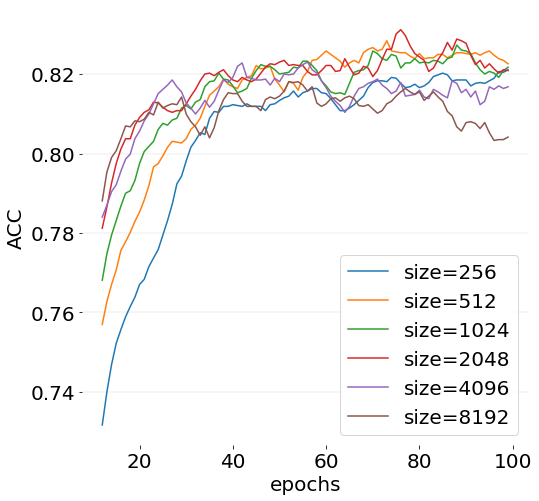

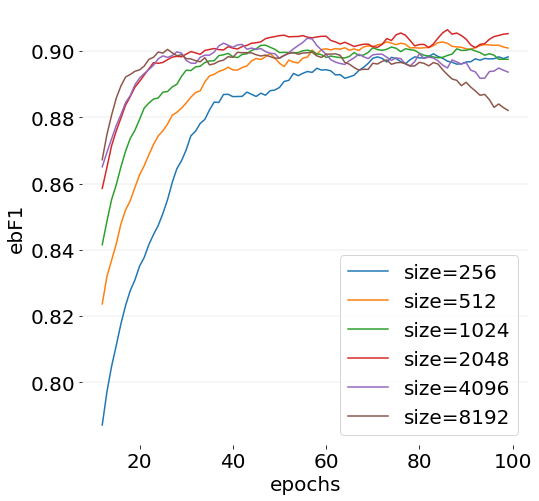

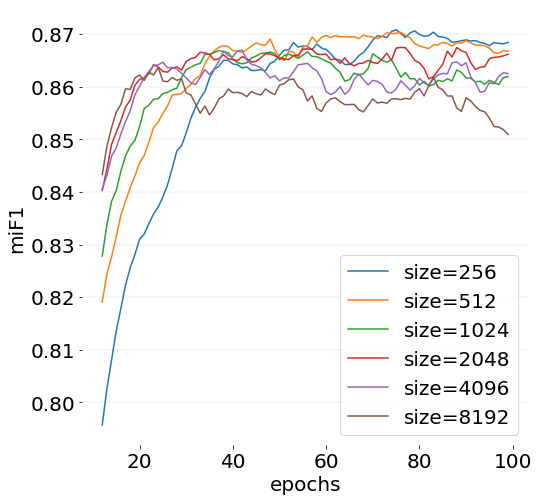

In [10]:
remove_first = 12

x = range(num_epochs)[remove_first:]
for display_name, metric_name in [("ACC", "perf/accuracy"), ("ebF1", "perf/ebF1"), ("miF1", "perf/miF1")]:
    pre, ax = plots.subplots(figsize=[8, 8], xlabel="epochs", ylabel=display_name)

    i = 0
    values = sorted(metrics.items(), key=lambda a: int(a[0][len("x_"):]))
    for name, metric in values:
        layers, size = map(int, name.split("_"))
        if layers == 2:
            y = [m[1] for m in metric["val"][metric_name]]
            y = plots.moving_average(y, window=6)
            y = y[remove_first:num_epochs]
            plots.plot(ax, x, y, color=i, label="size={}".format(size))
            i += 2

    ax.legend(loc=4)

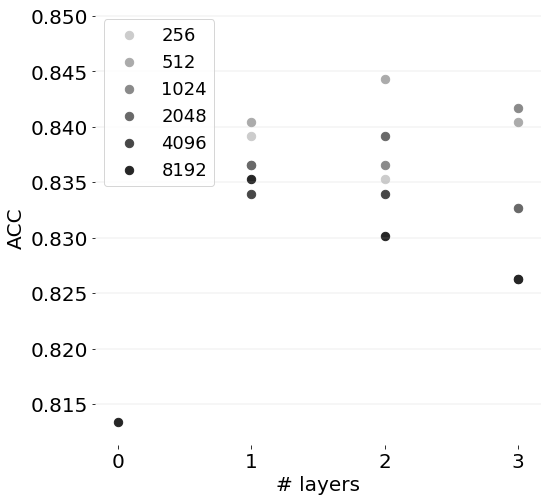

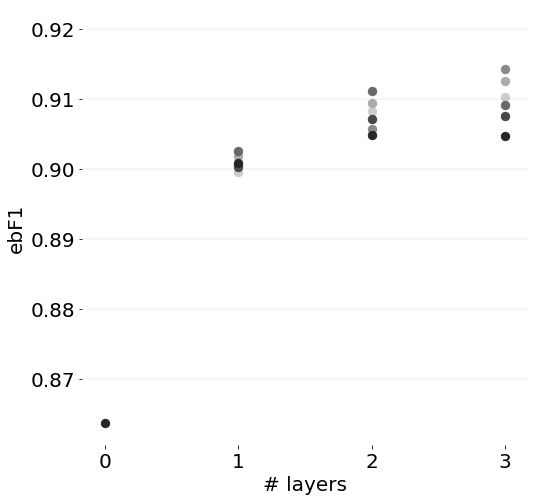

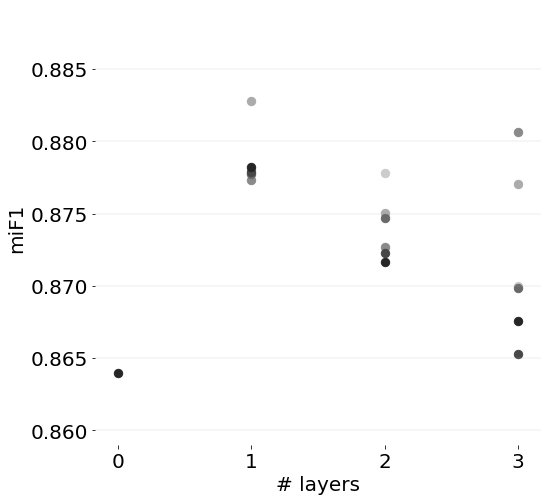

In [11]:
import math
from collections import defaultdict

first = True
for display_name, metric_name in [("ACC", "perf/accuracy"), ("ebF1", "perf/ebF1"), ("miF1", "perf/miF1")]:
    
    # Extract values
    result = defaultdict(list)
    values = sorted(metrics.items(), key=lambda a: int(a[0][len("x_"):]))
    for name, metric in values:
        layers, size = map(int, name.split("_"))
        # Ignore multiple runs of the 0-layers version
        if layers == 0 and size != 8192:
            continue
        y = max([m[1] for m in metric["val"][metric_name]])
        result[size].append((layers, y))

    # Plot with nr layers as X
    pre, ax = plots.subplots(figsize=[8, 8], xlabel="# layers", ylabel=display_name)
    result = sorted(result.items(), key=lambda a: int(a[0]))
    for i, (key, values) in enumerate(result):
        x, y = zip(*values)
        color = str(1. - min([i * .13 + .2, 1.0]))
        ax.scatter(x, y, color=color, s=70, label=str(key))
    ax.set_xticks(range(4))

    # Only show first legend
    if first:
        first = False
        ax.legend(loc=2, prop={'size': 18})

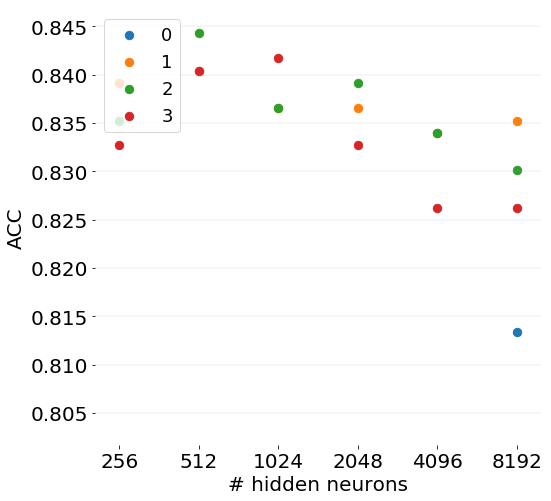

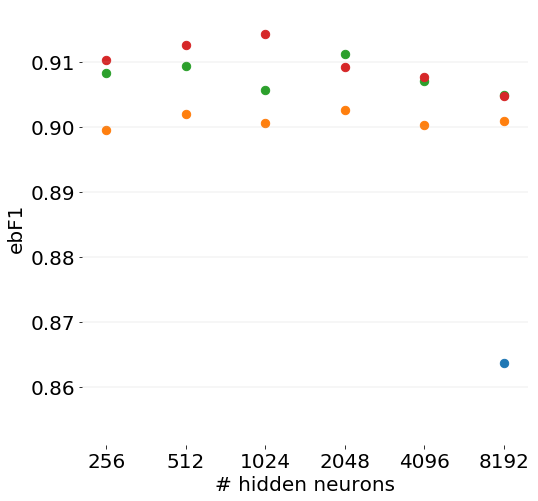

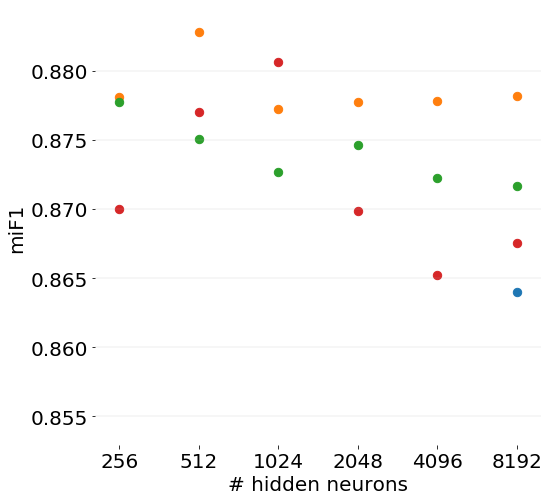

In [12]:
import math
from collections import defaultdict

first = True
for display_name, metric_name in [("ACC", "perf/accuracy"), ("ebF1", "perf/ebF1"), ("miF1", "perf/miF1")]:
    
    # Extract values
    result = defaultdict(list)
    values = sorted(metrics.items(), key=lambda a: int(a[0][len("x_"):]))
    for name, metric in values:
        layers, size = map(int, name.split("_"))
        if layers == 0 and size != 8192:
            continue
        y = max([m[1] for m in metric["val"][metric_name]])
        result[layers].append((size, y))

    # Plot with hidden size as X
    pre, ax = plots.subplots(figsize=[8, 8], xlabel="# hidden neurons", ylabel=display_name)
    for key, values in sorted(result.items(), key=lambda a: int(a[0])):
        x, y = zip(*values)
        x = list(map(lambda a: math.log(a, 2) - 8, x))
        ax.scatter(x, y, s=70, label=str(key))
    ax.set_xticks(range(6))
    ax.set_xticklabels([256, 512, 1024, 2048, 4096, 8192])

    # Only show first legend
    if first:
        first = False
        ax.legend(loc=2, prop={'size': 18})